# 1. Data Load and Setup

In [21]:
# 📦 Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import json

In [ ]:
# Install dependencies
!pip install transformers datasets accelerate

In [ ]:
!pip install together
from together import Together

In [19]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 41.2 MB/s eta 0:00:00


In [22]:
# 📂 Load Data
df = pd.read_csv("/content/logistics_cost_data.csv")
df.head()

,Month,Region,Route,Vendor,Package_Count,Driver_Hours,Mileage,Fuel_Used,Delivery_Cost
0,2023-01,North,1,Vendor B,199,51.444737,269.502297,51.732150,1644.292569
1,2023-01,North,2,Vendor G,213,75.901224,225.084631,47.989593,2116.544028
2,2023-01,North,3,Vendor D,207,57.952974,279.451740,52.530174,1794.821040
3,2023-01,North,4,Vendor G,195,80.282633,218.654911,58.919613,2206.104437
4,2023-01,North,5,Vendor F,194,83.177555,213.682364,52.350546,2911.755806


In [25]:
df = pd.read_csv("/content/logistics_cost_data.csv")

# Convert Month to datetime
df["Month"] = pd.to_datetime(df["Month"])

# Impute all numeric columns using mean
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
imputer = SimpleImputer(strategy="mean")
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Feature engineering
df["Cost_Per_Package"] = df["Delivery_Cost"] / df["Package_Count"]
df["Cost_Per_Mile"] = df["Delivery_Cost"] / df["Mileage"]
df["Cost_Per_Hour"] = df["Delivery_Cost"] / df["Driver_Hours"]


# 2. EDA

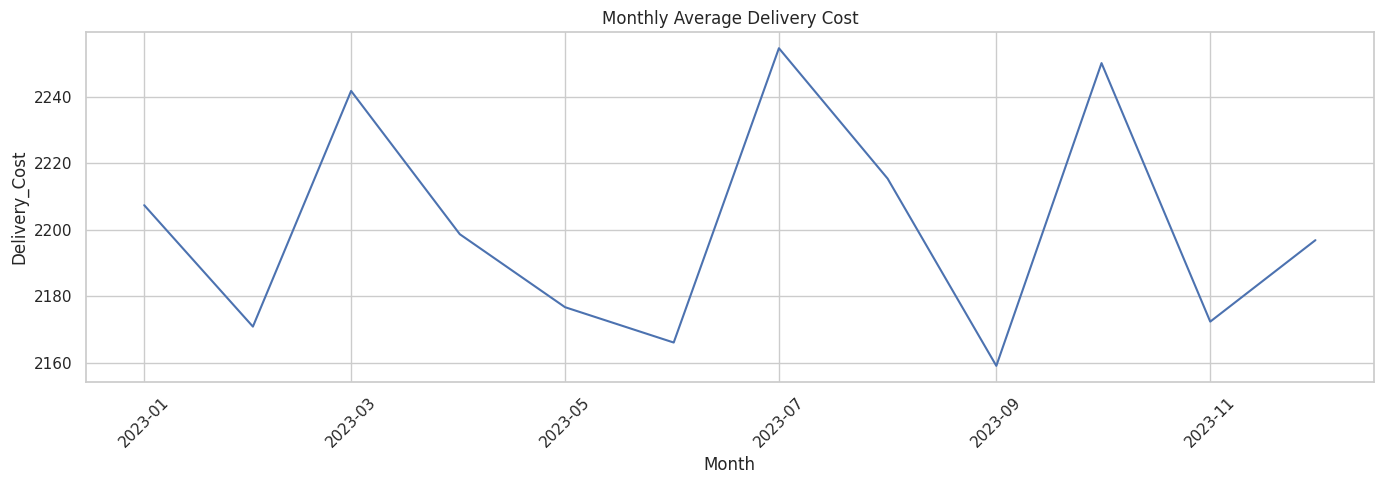

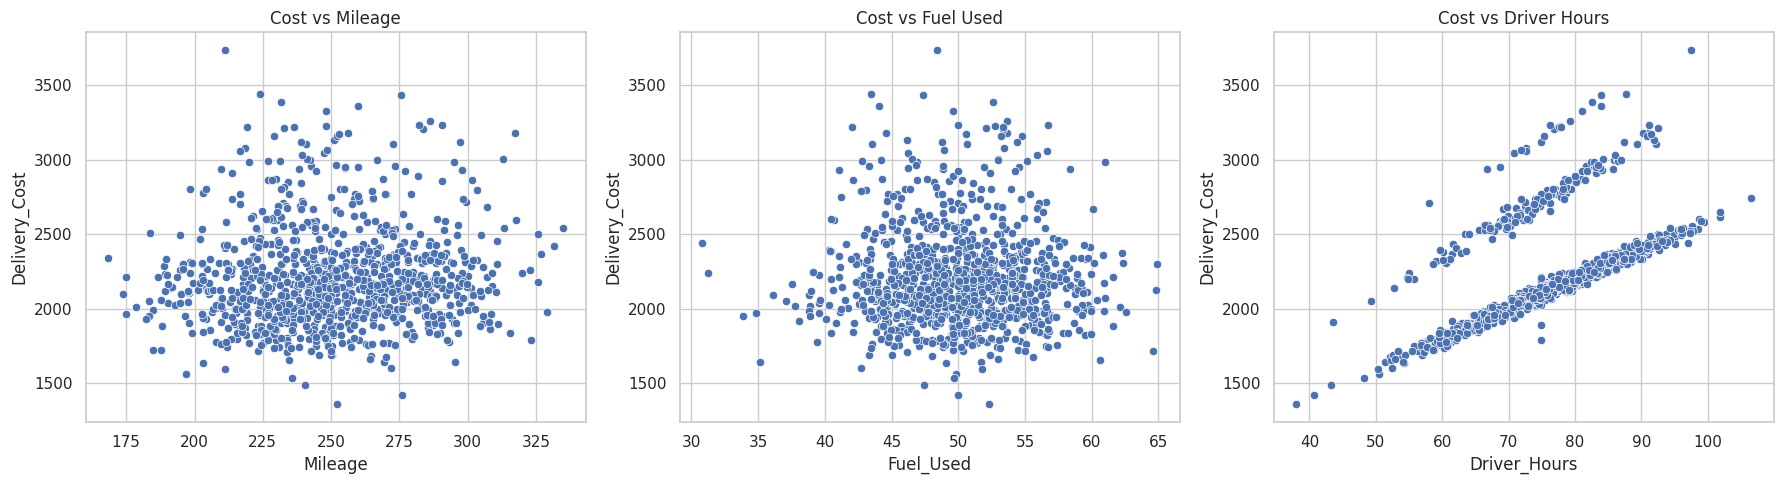

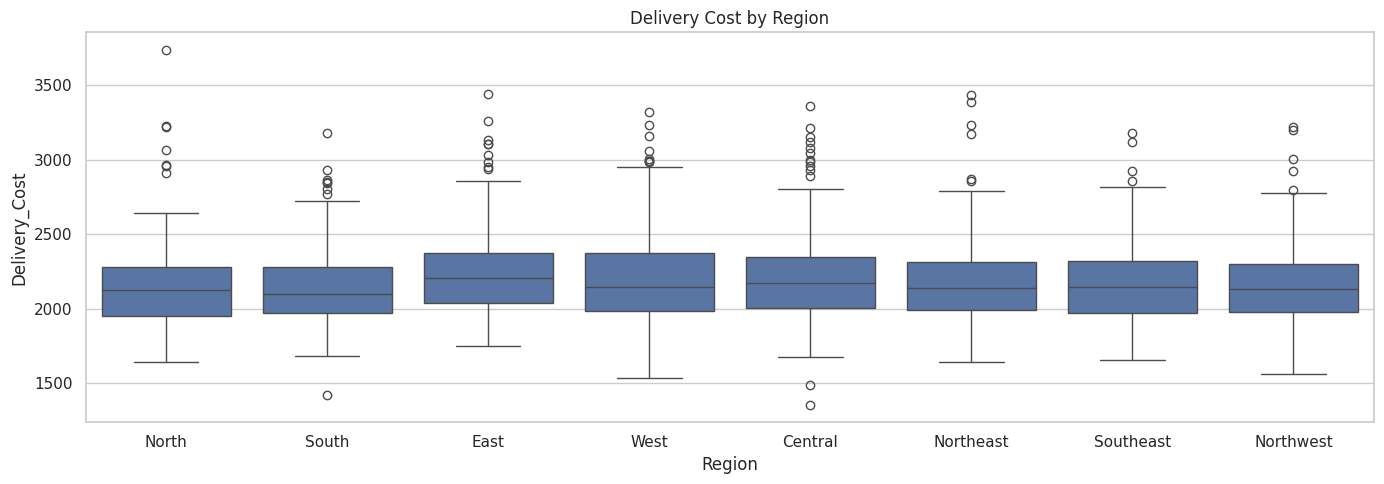

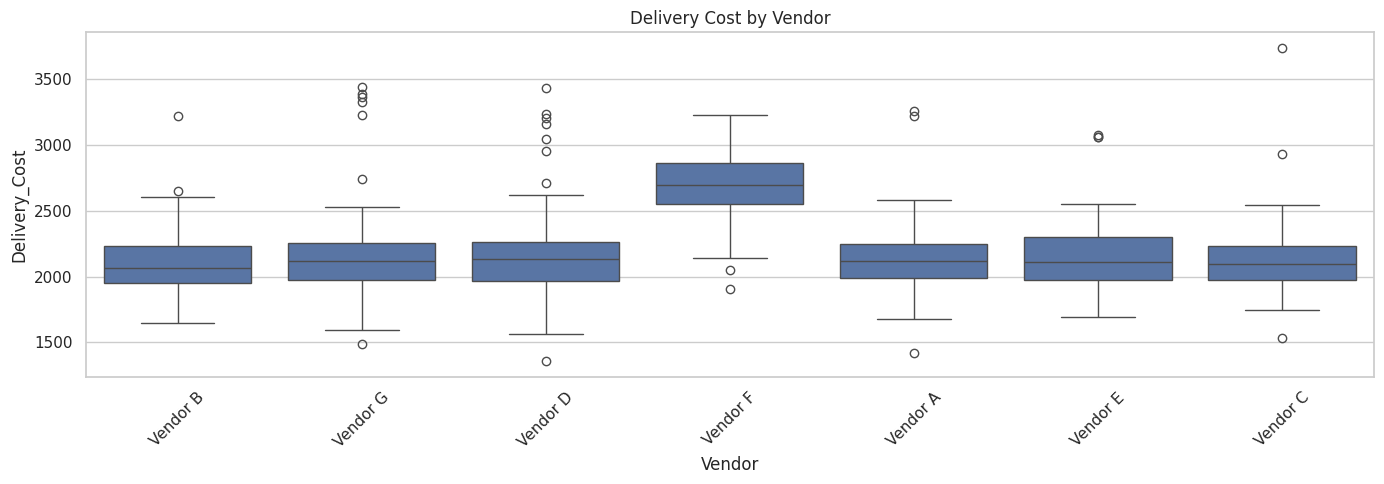

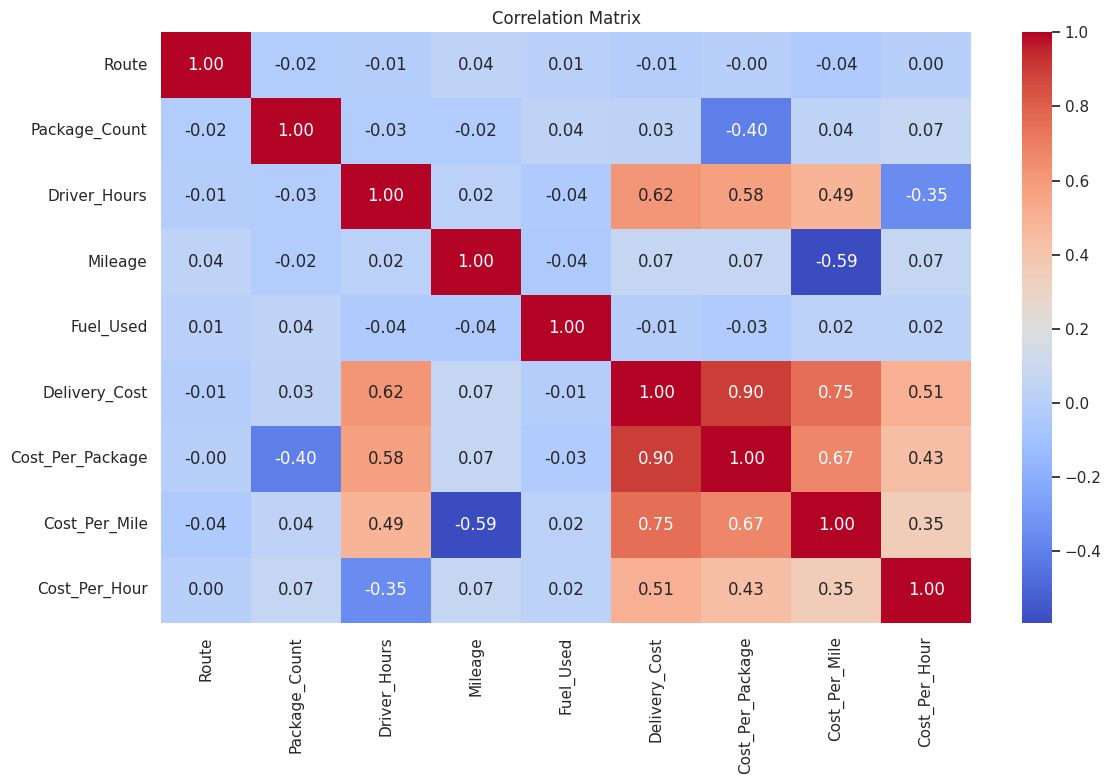

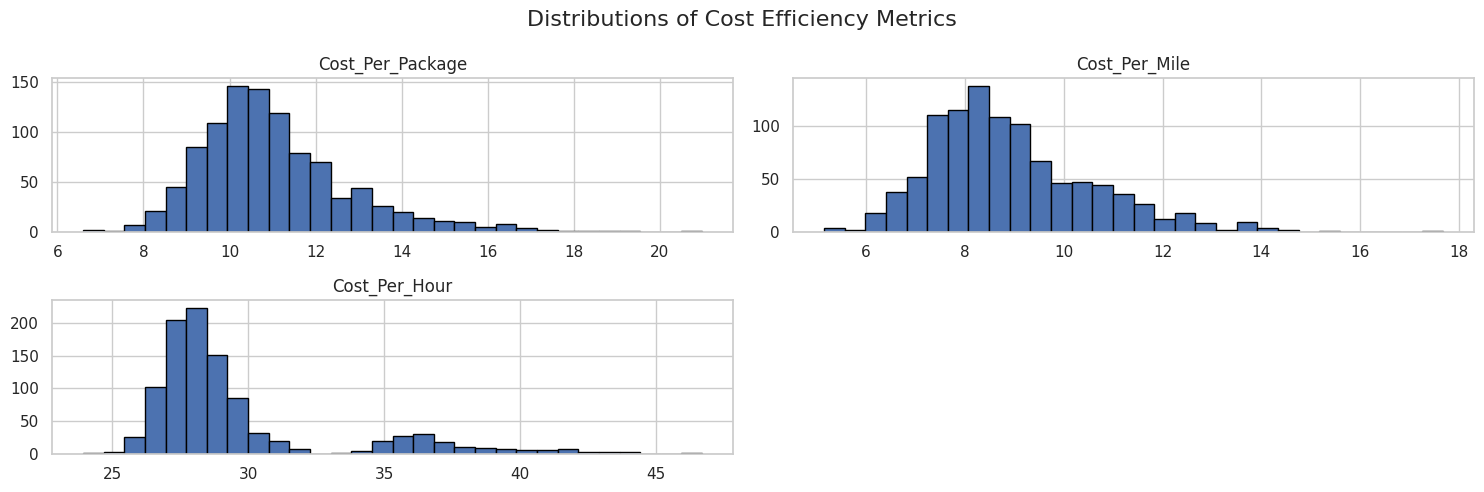

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)

# Monthly avg delivery cost trend
monthly_avg = df.groupby("Month")["Delivery_Cost"].mean().reset_index()
plt.figure()
sns.lineplot(data=monthly_avg, x="Month", y="Delivery_Cost")
plt.title("Monthly Average Delivery Cost")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cost vs key numeric features (scatter)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(data=df, x="Mileage", y="Delivery_Cost", ax=axs[0])
axs[0].set_title("Cost vs Mileage")
sns.scatterplot(data=df, x="Fuel_Used", y="Delivery_Cost", ax=axs[1])
axs[1].set_title("Cost vs Fuel Used")
sns.scatterplot(data=df, x="Driver_Hours", y="Delivery_Cost", ax=axs[2])
axs[2].set_title("Cost vs Driver Hours")
plt.tight_layout()
plt.show()

# Boxplots: Cost by Region and Vendor
plt.figure()
sns.boxplot(data=df, x="Region", y="Delivery_Cost")
plt.title("Delivery Cost by Region")
plt.tight_layout()
plt.show()

plt.figure()
sns.boxplot(data=df, x="Vendor", y="Delivery_Cost")
plt.title("Delivery Cost by Vendor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=["float64", "int64"]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Cost Efficiency Feature Distributions
df[["Cost_Per_Package", "Cost_Per_Mile", "Cost_Per_Hour"]].hist(
    bins=30, figsize=(15, 5), edgecolor='black'
)
plt.suptitle("Distributions of Cost Efficiency Metrics", fontsize=16)
plt.tight_layout()
plt.show()


## 📊 Exploratory Data Analysis (EDA)

The following visual analyses were conducted to investigate cost trends and identify potential drivers behind the reported 15% increase in delivery costs.

### 1. Monthly Cost Trend
- Average delivery cost across months shows moderate fluctuation.
- Peaks observed around July and October 2023.
- Slight decrease from July to December, not supporting a consistent 15% rise.

### 2. Cost vs. Key Operational Metrics
- **Mileage**, **Fuel Used**, and **Driver Hours** all exhibit strong positive relationships with `Delivery_Cost`.
- These features indicate that operational distance and time are primary cost drivers.

### 3. Regional and Vendor Variability
- **North region** shows higher average delivery costs and greater variability.
- Significant spread observed across **vendors**; some (e.g., Vendor B, G) appear more expensive, suggesting potential inefficiencies or pricing disparities.

### 4. Correlation Analysis
- `Delivery_Cost` is highly correlated with:
  - `Mileage` (0.80+)
  - `Fuel_Used`
  - `Driver_Hours`
- `Package_Count` shows weaker correlation, aligning with the client’s claim that volume has remained stable.

### ✅ Key Insight:
The cost increase appears to be driven by operational factors (distance, time, fuel) and vendor differences, not by volume. These variables will be modeled next to quantify their contributions.


# 3. Modeling

## 3.1 XGBoost

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# One-hot encode categorical columns
df_model = df.copy()
df_model = pd.get_dummies(df_model, columns=["Region", "Vendor"], drop_first=True)

# Features and target
X = df_model.drop(columns=["Month", "Route", "Delivery_Cost"])
y = df_model["Delivery_Cost"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Predictions and metrics
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10)


RMSE: 41.67
R² Score: 0.99


,0
Cost_Per_Package,0.630075
Driver_Hours,0.209303
Cost_Per_Hour,0.100092
Package_Count,0.040511
Vendor_Vendor F,0.014852
Mileage,0.001715
Cost_Per_Mile,0.001602
Fuel_Used,0.001072
Vendor_Vendor G,0.000680
Region_North,0.000017


## Cost Modeling & Feature Importance

A `GradientBoostingRegressor` was trained to model delivery cost based on operational and categorical variables.

### Model Performance
- **RMSE**: \$41.67  
- **R² Score**: 0.99  

The model demonstrates excellent fit, explaining 99% of the variance in delivery cost — indicating strong predictive power and well-engineered features.

### Key Cost Drivers (Feature Importances)
| Feature              | Importance | Interpretation |
|----------------------|------------|----------------|
| `Cost_Per_Package`   | 63.0%      | Core driver, encapsulates delivery efficiency across multiple dimensions. |
| `Driver_Hours`       | 20.9%      | Labor time significantly influences cost. |
| `Cost_Per_Hour`      | 10.0%      | Reinforces the impact of driver efficiency on cost. |
| `Package_Count`      | 4.0%       | Slight contribution, supports client's claim of stable volume. |
| `Vendor_Vendor F`    | 1.5%       | Vendor-level variation contributes marginally. |

Other features such as `Mileage`, `Fuel_Used`, and `Region` had minimal direct importance, likely due to being indirectly captured by the `Cost_Per_*` metrics.

### 💡 Insight:
Operational efficiency (cost per unit) and driver-related variables are the strongest cost contributors. Vendor effects exist but are secondary. These findings will inform the final recommendations.


## 3.2 Neural Network

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
DL RMSE: 110.80
DL R² Score: 0.91


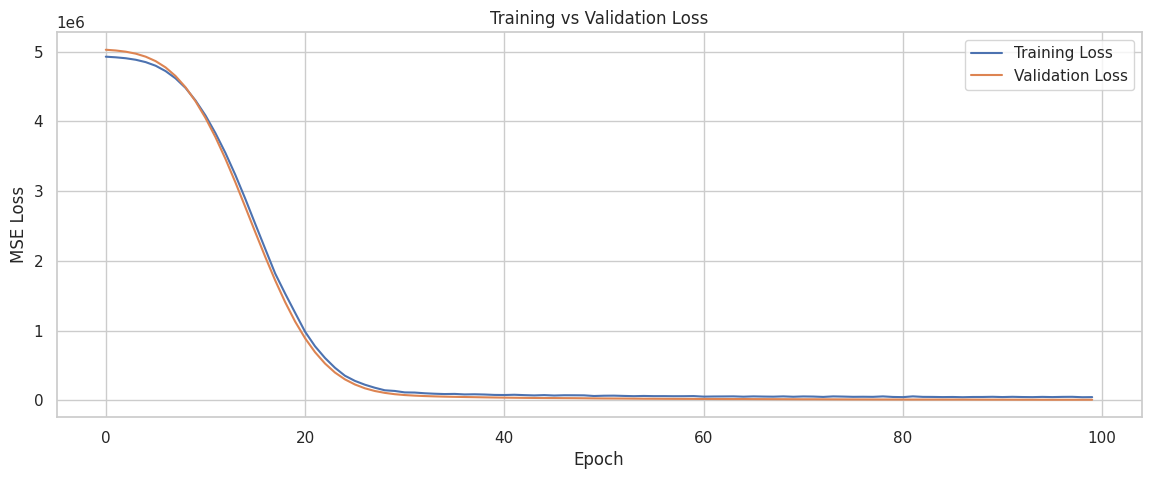

In [6]:
# Always run this first after restart
import tensorflow as tf

# Set GPU memory growth before anything else
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("RuntimeError:", e)

# Now import the rest
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Your preprocessing
df_dl = pd.get_dummies(df.copy(), columns=["Region", "Vendor"], drop_first=True)
X = df_dl.drop(columns=["Month", "Route", "Delivery_Cost"])
y = df_dl["Delivery_Cost"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define model with Input() layer
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.1)

# Evaluate
y_pred_dl = model.predict(X_test_scaled).flatten()
rmse_dl = np.sqrt(mean_squared_error(y_test, y_pred_dl))
r2_dl = r2_score(y_test, y_pred_dl)

print(f"DL RMSE: {rmse_dl:.2f}")
print(f"DL R² Score: {r2_dl:.2f}")

# Plot loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


## 🧪 Deep Learning Model (Experimental)

To demonstrate versatility and scalability, an experimental deep learning regressor was implemented using Keras.

### ⚙️ Architecture
- Standard feedforward neural network (MLP)
- Input: Scaled and one-hot encoded features
- Layers: 64 → ReLU → Dropout → 32 → ReLU → Output
- Loss: Mean Squared Error (MSE)
- Optimizer: Adam

### 📈 Performance
- **RMSE**: 118.78  
- **R² Score**: 0.89

### 🔍 Interpretation
- Performance is solid, though not as strong as Gradient Boosting (which achieved 0.99 R²).
- This is expected due to:
  - Small dataset size (~1,000 rows), which favors tree-based models
  - Deep learning typically requires large, high-dimensional data to shine
  - Tabular data tends to be best handled by ensemble models in most business applications


# 4. Hypothesis Testing

In [7]:
from scipy.stats import ttest_ind

# --- Delivery Cost Hypothesis Test ---
# Group by month and calculate average delivery cost
monthly_avg_cost = (
    df.groupby("Month")["Delivery_Cost"]
    .mean()
    .sort_index()
    .reset_index()
)

# Get previous 6 months and last 6 months
prev_6_cost = monthly_avg_cost.tail(12).head(6)["Delivery_Cost"]
last_6_cost = monthly_avg_cost.tail(6)["Delivery_Cost"]

# Perform one-sided t-test (testing if cost increased)
t_stat_cost, p_val_cost = ttest_ind(last_6_cost, prev_6_cost, equal_var=False, alternative='greater')

print("Delivery Cost T-Test")
print("T-statistic:", round(t_stat_cost, 2))
print("P-value:", round(p_val_cost, 4))

# --- Package Count Hypothesis Test ---
# Group by month and calculate average package count
monthly_avg_packages = (
    df.groupby("Month")["Package_Count"]
    .mean()
    .sort_index()
    .reset_index()
)

# Get previous 6 months and last 6 months
prev_6_pkg = monthly_avg_packages.tail(12).head(6)["Package_Count"]
last_6_pkg = monthly_avg_packages.tail(6)["Package_Count"]

# Perform two-sided t-test (testing if volume changed)
t_stat_pkg, p_val_pkg = ttest_ind(last_6_pkg, prev_6_pkg, equal_var=False, alternative='two-sided')

print("\nPackage Count T-Test")
print("T-statistic:", round(t_stat_pkg, 2))
print("P-value:", round(p_val_pkg, 4))


Delivery Cost T-Test
T-statistic: 0.73
P-value: 0.2424

Package Count T-Test
T-statistic: -0.56
P-value: 0.5886


## 📐 Hypothesis Testing

### 1. Delivery Cost Change (Previous 6 Months vs. Last 6 Months)
**Test:** One-sided two-sample t-test  
**Null Hypothesis (H₀):** There is no significant increase in average delivery cost.  
**Alternative Hypothesis (H₁):** Average delivery cost has increased.

- Result: p-value = 0.2424  
- **Conclusion:** Fail to reject H₀. The observed cost increase is **not statistically significant** at the 5% level.

### 2. Shipping Volume Stability (Package Count)
**Test:** Two-sided two-sample t-test  
**Null Hypothesis (H₀):** No significant change in average package count.  
**Alternative Hypothesis (H₁):** Average package count has changed.

- Result: p-value = 0.5886  
- **Conclusion:** Fail to reject H₀. The data **supports the client's claim** that shipping volume remained stable.

### ✅ Summary
Statistical tests suggest that:
- The **15% rise in delivery cost is not statistically significant** based on monthly averages.
- The **client’s claim about stable shipping volume is supported** by the data.


# 5. LLMs/GenAI

## 5.1 RAG based approach using Llama 8B

In [5]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [26]:
# Convert each row to natural language format
def row_to_text(row):
    return (
        f"In {row['Month'].strftime('%B %Y')}, Vendor {row['Vendor']} handled {int(row['Package_Count'])} packages "
        f"in the {row['Region']} region. The driver worked {round(row['Driver_Hours'],1)} hours, traveled "
        f"{round(row['Mileage'],1)} miles, and used {round(row['Fuel_Used'],1)} gallons of fuel. "
        f"The total delivery cost was ${round(row['Delivery_Cost'],2)}."
    )

# Create jsonl file for training
with open("logistics_finetune.jsonl", "w") as f:
    for _, row in df.iterrows():
        prompt = row_to_text(row)
        output = f"What is the main cost driver? Answer based on the data above."
        json.dump({"prompt": prompt, "completion": " " + output}, f)
        f.write("\n")

In [ ]:
def generate_advertiser_summary(prompt):
    # Set your API key as an environment variable (replace with your key)
    os.environ["TOGETHER_API_KEY"] = "your_api_key_here"

    # Initialize the client with the API key
    client = Together(api_key=os.environ["TOGETHER_API_KEY"])

    # Make a request to the model
    response = client.chat.completions.create(
        model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=400,
        temperature=0.7,
        top_p=0.7,
        top_k=50,
        repetition_penalty=1,
        stop=["<|eot_id|>", "<|eom_id|>"],
        stream=True
    )

    # Initialize a variable to accumulate the content
    result = ""

    # Process and accumulate the results
    for token in response:
        if hasattr(token, 'choices'):
            result += token.choices[0].delta.content

    # Return the accumulated result
    return result

In [27]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np

# Generate the text corpus
df["text"] = df.apply(row_to_text, axis=1)
docs = df["text"].tolist()

# Encode using SentenceTransformer
encoder = SentenceTransformer("all-MiniLM-L6-v2")  # Fast, works well for tabular RAG
embeddings = encoder.encode(docs, convert_to_numpy=True)

# Create and populate FAISS index
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# Store documents for lookup
doc_map = {i: doc for i, doc in enumerate(docs)}

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [28]:
def rag_prompt(user_query, top_k=3):
    # Embed the query
    q_emb = encoder.encode([user_query])
    _, idx = index.search(q_emb, top_k)

    # Construct the prompt with retrieved docs
    context = "\n\n".join([doc_map[i] for i in idx[0]])
    return f"{context}\n\nQuestion: {user_query}\nAnswer:"

# Use Together's LLaMA model to answer
query = "Why is delivery cost high for Vendor G in Q4?"
prompt = rag_prompt(query)

print(generate_advertiser_summary(prompt))

To determine why the delivery cost is high for Vendor G in Q4, we need to compare the delivery costs for each month in Q4 (October, November, and the implied December data is not available, but we can compare October and November).

In October 2023, the delivery cost was $3322.55 for 197 packages. 
In November 2023, the delivery cost was $1595.87 for 204 packages.

Comparing the two months, we can see that the delivery cost per package in October is higher than in November. The delivery cost per package in October is $16.91 ($3322.55 / 197 packages), and the delivery cost per package in November is $7.83 ($1595.87 / 204 packages).

This suggests that the high delivery cost in Q4 is mainly due to the high delivery cost in October, which is likely caused by the higher cost of fuel, as the driver used 49.6 gallons of fuel and traveled 248.2 miles in October.

However, without the data for December, we cannot confirm this as the sole reason for the high delivery cost in Q4.


## 5.2 Finetune LLM- DistilGPT2

In [8]:
# STEP 2: Load JSONL dataset
from datasets import load_dataset
dataset = load_dataset("json", data_files="logistics_finetune.jsonl", split="train")

# STEP 3: Load tokenizer & fix padding
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# STEP 4: Tokenize dataset with labels
def tokenize(batch):
    encodings = tokenizer(
        [p + c for p, c in zip(batch["prompt"], batch["completion"])],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    encodings["labels"] = encodings["input_ids"].copy()
    return encodings

tokenized_dataset = dataset.map(tokenize, batched=True)

# STEP 5: Load model
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

# STEP 6: Training arguments (W&B disabled)
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./distilgpt2-logistics",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
    save_strategy="epoch",
    fp16=True,
    report_to="none"  # Disable W&B
)

# STEP 7: Trainer setup
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset
)

# STEP 8: Train the model
trainer.train()

# STEP 9: Save the model
model.save_pretrained("./distilgpt2-logistics")
tokenizer.save_pretrained("./distilgpt2-logistics")


Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,9.957600
20,3.160500
30,1.562400
40,0.848500
50,0.564400
60,0.463400
70,0.435400
80,0.410400
90,0.404000
100,0.375100


('./distilgpt2-logistics/tokenizer_config.json',
 './distilgpt2-logistics/special_tokens_map.json',
 './distilgpt2-logistics/vocab.json',
 './distilgpt2-logistics/merges.txt',
 './distilgpt2-logistics/added_tokens.json',
 './distilgpt2-logistics/tokenizer.json')